In [2]:
from huggingface_hub import notebook_login,get_full_repo_name
notebook_login()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
baseline_model_name='Mahloromela/Baseline-Swahili-Classifier-cola'
finetuned_model_name = 'Mahloromela/Swahili-Classifier-cola'

Using device: cpu


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


model.safetensors:   0%|          | 0.00/332M [00:00<?, ?B/s]


Results for Baseline Model:
ACCURACY: 0.8900
PRECISION: 0.8902
RECALL: 0.8900
F1: 0.8900
ROC_AUC: 0.9696


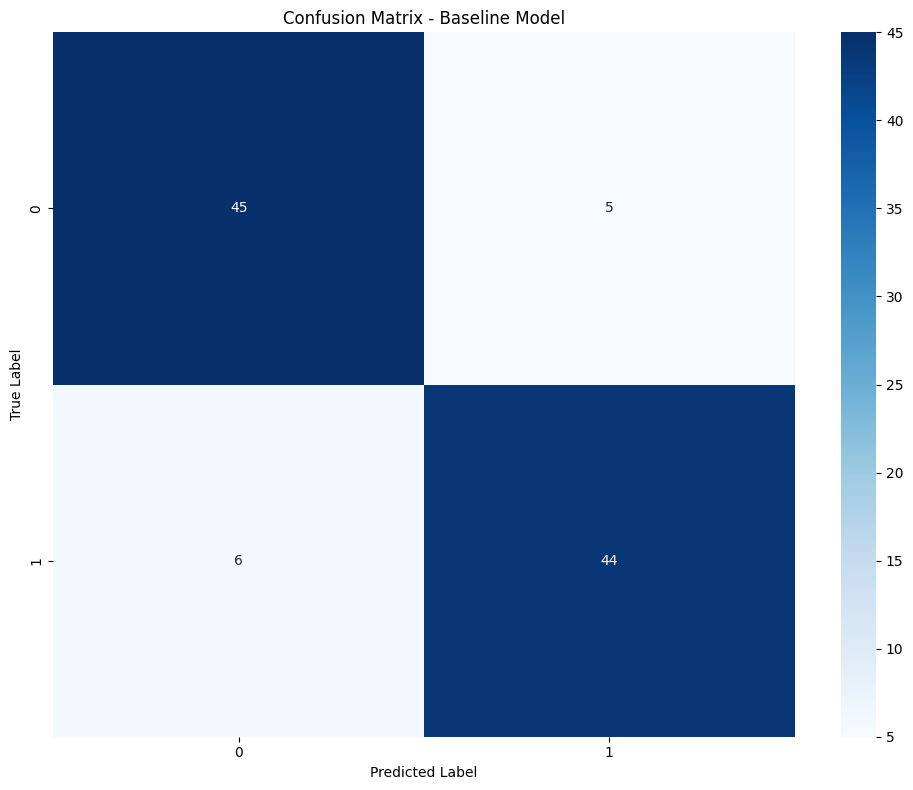

Using device: cpu


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Results for Fine-tuned Model:
ACCURACY: 0.8500
PRECISION: 0.8617
RECALL: 0.8500
F1: 0.8488
ROC_AUC: 0.9468


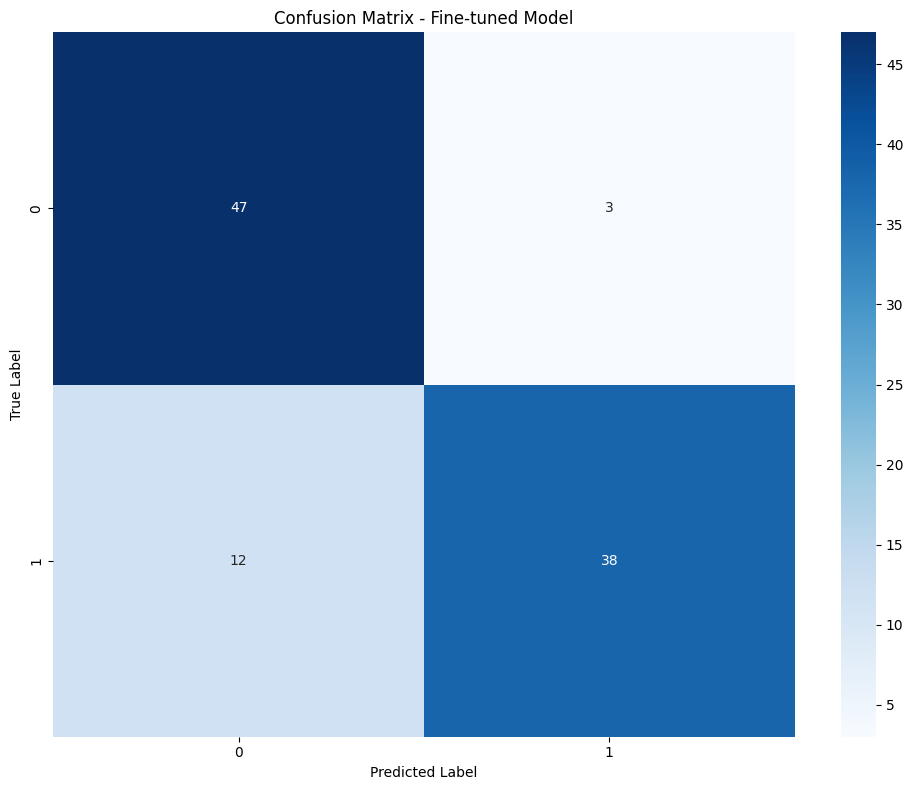

In [13]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

def load_model_and_tokenizer(model_path: str) -> Tuple[AutoModelForSequenceClassification, AutoTokenizer]:
    """
    Load the model and tokenizer from the specified path.
    """
    tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_small")
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    return model, tokenizer

def prepare_data(texts: list, labels: list, tokenizer: AutoTokenizer,
                max_length: int = 512, batch_size: int = 16) -> Tuple[DataLoader, LabelEncoder]:
    """
    Prepare data with proper padding and create a DataLoader.
    Handles both numeric and string labels.
    """
    # Convert string labels to numeric using LabelEncoder
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)

    # Tokenize with padding and truncation
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Create dataset
    dataset = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(numeric_labels, dtype=torch.long)
    )

    # Create dataloader
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), label_encoder

def get_predictions(model: AutoModelForSequenceClassification,
                   data_loader: DataLoader,
                   device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get model predictions using batched processing.
    """
    model.eval()
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, _ = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)

            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())

    return np.array(all_predictions), np.array(all_probabilities)

def calculate_metrics(y_true: np.ndarray, predictions: np.ndarray,
                     probabilities: np.ndarray) -> Dict[str, float]:
    """
    Calculate all relevant metrics for the model evaluation.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, predictions),
        'precision': precision_score(y_true, predictions, average='weighted'),
        'recall': recall_score(y_true, predictions, average='weighted'),
        'f1': f1_score(y_true, predictions, average='weighted')
    }

    # Only add ROC AUC if it's a binary classification
    if probabilities.shape[1] == 2:
        metrics['roc_auc'] = roc_auc_score(y_true, probabilities[:, 1])

    return metrics

def evaluate_model(model_path: str, test_data_path: str, model_name: str) -> Dict[str, float]:
    """
    Evaluate a model and print/save all relevant metrics and visualizations.
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load model and data
    model, tokenizer = load_model_and_tokenizer(model_path)
    model.to(device)
    df_test = pd.concat([pd.read_csv(test_data_path)[pd.read_csv(test_data_path)['label']==label].sample(n=50, random_state=42) for label in [0,1]]).sample(frac=1, random_state=42)

    # Prepare data loader
    data_loader, label_encoder = prepare_data(
        df_test['text'].tolist(),
        df_test['label'].tolist(),
        tokenizer
    )

    # Get predictions
    predictions, probabilities = get_predictions(model, data_loader, device)

    # Calculate metrics using original labels
    metrics = calculate_metrics(
        label_encoder.transform(df_test['label'].values),
        predictions,
        probabilities
    )

    # Print metrics
    print(f"\nResults for {model_name}:")
    print("=" * 50)
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(
        label_encoder.transform(df_test['label'].values),
        predictions,
        model_name,
        label_encoder.classes_
    )

    return metrics

def plot_confusion_matrix(y_true: np.ndarray, predictions: np.ndarray,
                         title: str, class_names: np.ndarray) -> None:
    """
    Plot and save confusion matrix with proper class labels.
    """
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

def compare_models(baseline_metrics: Dict[str, float], finetuned_metrics: Dict[str, float]) -> None:
    """
    Compare and visualize the performance of baseline and finetuned models.
    """
    metrics = list(baseline_metrics.keys())
    baseline_values = list(baseline_metrics.values())
    finetuned_values = list(finetuned_metrics.values())

    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, baseline_values, width, label='Baseline')
    plt.bar(x + width/2, finetuned_values, width, label='Fine-tuned')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Baseline vs Fine-tuned Model Performance')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    plt.close()

# Main execution
if __name__ == "__main__":
    # Evaluate baseline model
    baseline_metrics = evaluate_model(
        model_path= baseline_model_name,
        test_data_path='/content/drive/MyDrive/NLP Project/test_data1.csv',
        model_name='Baseline Model'
    )

    # Evaluate fine-tuned model
    finetuned_metrics = evaluate_model(
        model_path=finetuned_model_name,
        test_data_path='/content/drive/MyDrive/NLP Project/test_data1.csv',
        model_name='Fine-tuned Model'
    )

    # Compare models
    compare_models(baseline_metrics, finetuned_metrics)

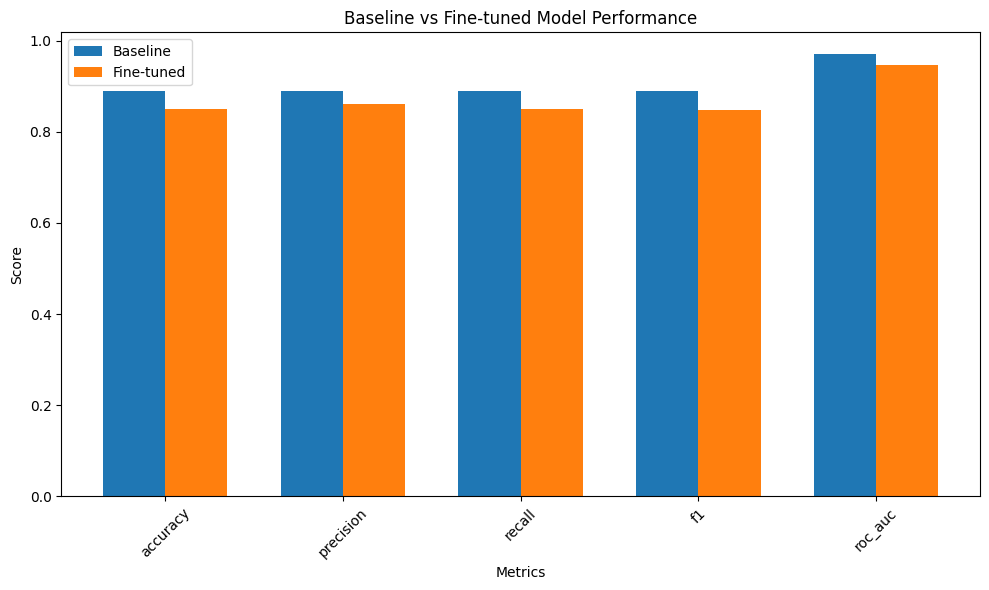

In [14]:
  compare_models(baseline_metrics, finetuned_metrics)